In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime

dataset_path = '../data/raw/export_df.parquet'

ČLANAK https://arxiv.org/pdf/2004.00433.pdf

- An outlier is an observation with at least one variable having an unusual value.
- A univariate outlier is an observation with a variable that has an unusual value.
- A multivariate outlier is an observation with at least two variables having unusual values.

# Predprocesuiranje podataka

In [2]:
data = pd.read_parquet(dataset_path)
data.head()


,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


#### Uklanjanje zapisa (redaka) gdje je zemlja gosta 0 

In [3]:
data = data[~(data['zemlja_gosta']=='0')]

#### Uklanjanje radaka s otkazanim rezervacijama

Zasada se fokusiramo na otklanjanjem outliera kod pojedinih hotela i to za ostvarene dolaske, moguće je proširiti na anomalije
 i kod otkazivanja, što bi ukazivalo da je neočekivana potražnja za hotelom te bi se možda moglo tumačiti zbog čega je došlo do toga, ali isto je tako korisno i ako vidimo da je veći broj otkazivanja kod cijenovnih anomalija
 

In [4]:
data = data[~data['datum_otkazivanja_rezervacije'].notna()]
data = data.reset_index(drop=True)
data.head(5)

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


#### Dodavanje stupca duljina_boravka

In [5]:
data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
data['duljina_boravka'] = data['duljina_boravka'].dt.days
data.head(10)


,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id,duljina_boravka
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152,0
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906,0
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896,1
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245,1
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703,2
5,0,2015-07-01,2015-04-21,2015-07-03,None,2,0.0,GBR,2,1,143.304560,Check-Out,1313228,1044263,2
6,0,2015-07-01,2015-06-25,2015-07-03,None,2,0.0,PRT,0,0,161.502814,Check-Out,1313229,1022260,2
7,0,2015-07-01,2014-09-15,2015-07-03,None,2,0.0,PRT,0,0,151.176542,Check-Out,1313230,1101557,2
8,0,2015-07-01,2014-10-14,2015-07-05,None,2,0.0,PRT,2,2,215.197422,Check-Out,1313234,1094841,4
9,0,2015-07-01,2015-03-16,2015-07-05,None,2,0.0,USA,2,2,63.461672,Check-Out,1313235,1025429,4


#### Dodavanje stupca  ukupno_gostiju ; broj djece za svaki redak (djeca + odrasli)

In [6]:
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']

##### Uklanjanje rezervacija u kojima nema gostiju, odnosno ukupan je broj gostiju 0

NOTE: Zašto ove retke uklanjamo sada, a ne nakon primjene statističke ili metode strojnog učenja? Jer ovdje govorimo o retcima u kojima je broj gpstiju nula, što znači kako su ti podaci nevaljani: označen je dolazak gosta, odnosno očekujemo da je gost došao, ali je zbog nekog razloga krivo postavljen broj gostiju te možemo reći da su ovdje krivo uneseni podaci

In [7]:
data = data[data['ukupno_gostiju'] != 0]

#### Dodavanje stupca raspon_dolazak_rezervacija

In [8]:
data['raspon_dolazak_rezervacija'] = (data['datum_dolaska'] - data['datum_kreiranja_rezervacije']).dt.days

####  Uklanjanje stupaca: 
   - datum otkazivanja rezervacije (ovdej imamo samo neotkazane rezervacije)
   - datum odjave : jer je autokoreliran s stupcima datum dolaska i duljina boravka
   - broj_odraslih_gostiju	te broj_djece_gostiju uklanjamo kako smo dodali stupac ukupan broj gostiju
   - status rezervacije (sve su vrijednosti iste iste - 'Check-Out')
   - rezervacija_id - od 74553 zapisa imamo i 74553 unikatne vrijednosti identifikatora
    (NE ODBACUJEMO gost_id jer od 74553 zapisaimamo 69764 gosta, što znači da imamo ponavljajućih gostiju)
   - datun_kreiranja_rezervacije - dodan je stupac raspon_dolazak_rezervacija koji označava razliku dana dolaska i kreiranja rezervacije 
   

In [9]:
data = data.drop(columns = ['datum_otkazivanja_rezervacije','datum_odjave','broj_odraslih_gostiju','broj_djece_gostiju','status_rezervacije','rezervacija_id','datum_kreiranja_rezervacije'],axis=1)
data.head()

,hotel_id,datum_dolaska,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,gost_id,duljina_boravka,ukupno_gostiju,raspon_dolazak_rezervacija
0,0,2015-07-01,PRT,0,0,100.000000,1077152,0,2.0,161
1,0,2015-07-01,PRT,0,0,100.000000,1017906,0,2.0,21
2,0,2015-07-01,GBR,0,1,64.991345,1039896,1,1.0,49
3,0,2015-07-01,GBR,1,1,74.368897,1008245,1,1.0,397
4,0,2015-07-01,GBR,2,1,130.973278,1093703,2,2.0,360


In [10]:
# data['datum_dolaska'] = pd.to_datetime(data['datum_dolaska'], errors='coerce')
# data.set_index('datum_dolaska', inplace=True)

In [11]:
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

- Na kojeme vremenskom okviru gledati outliere? 
- Kako pohraniti podatke na tjednoj razini u neku smislenu cjelinu?
    (agregacija na tjednoj razini u neku smislenu cjelinu, pogotovo s kategoričkim varijablama)

# Tjedna razina (promatramo tjednu fluktuaciju broja gostiju) za oba hotela

In [12]:
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('W').sum().to_frame()
NumberOfGuestsWeeklyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-04,35.0
2015-01-11,42.0
2015-01-18,54.0
2015-01-25,48.0
2015-02-01,27.0


In [14]:
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('W').sum().to_frame()
NumberOfGuestsWeeklyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-05,358.0
2015-07-12,495.0
2015-07-19,537.0
2015-07-26,533.0
2015-08-02,554.0


## Naivan pristup : interkvartalni rang

 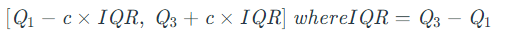

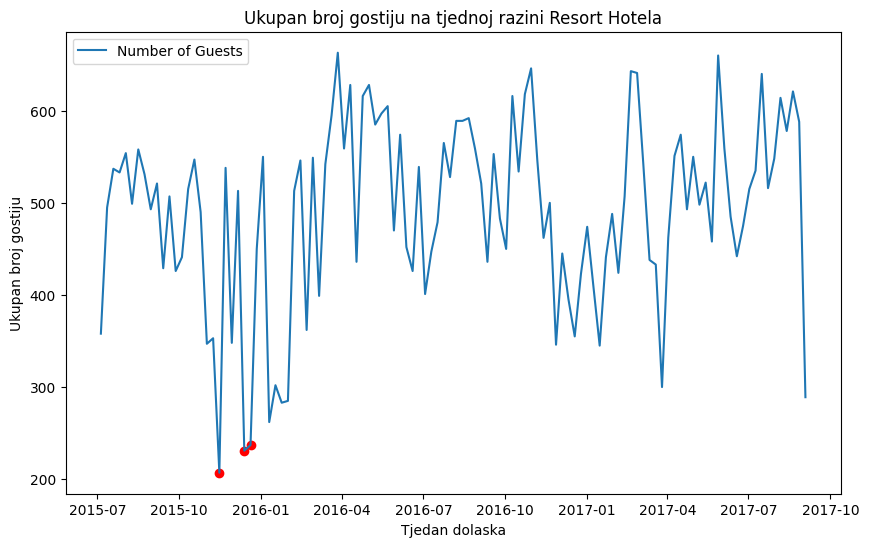

In [15]:
q11 = np.percentile(NumberOfGuestsWeeklyResort['ukupno_gostiju'], 25)
q31 = np.percentile(NumberOfGuestsWeeklyResort['ukupno_gostiju'],75)
iqr1 = q31 - q11
threshold1 = 1.5 * iqr1
outliers1 = np.where((NumberOfGuestsWeeklyResort['ukupno_gostiju'] < q11 - threshold1) | (NumberOfGuestsWeeklyResort['ukupno_gostiju'] > q31 + threshold1))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers1[0]:
    plt.scatter(NumberOfGuestsWeeklyResort.index[outlier], NumberOfGuestsWeeklyResort['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini Resort Hotela')
plt.legend()
plt.show()


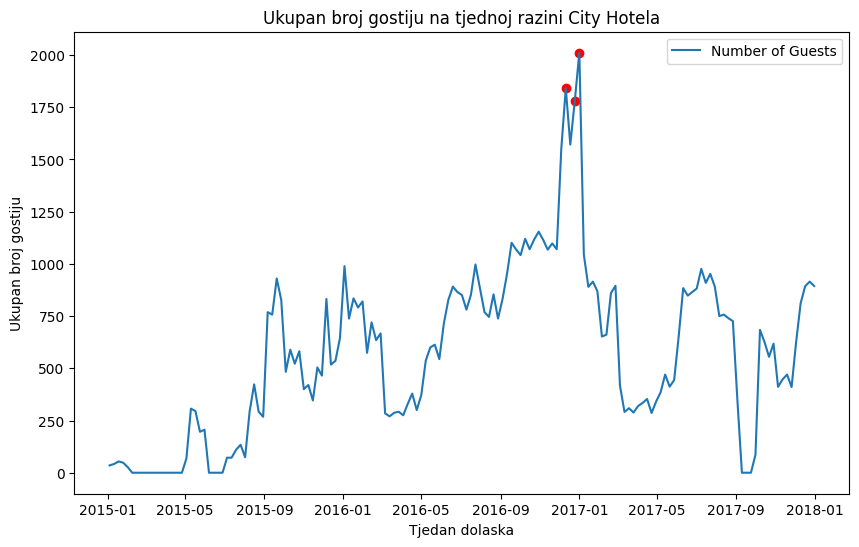

In [16]:
q12 = np.percentile(NumberOfGuestsWeeklyCity['ukupno_gostiju'], 25)
q32 = np.percentile(NumberOfGuestsWeeklyCity['ukupno_gostiju'],75)
iqr2 = q32 - q12
threshold2 = 1.5 * iqr2
outliers2 = np.where((NumberOfGuestsWeeklyCity['ukupno_gostiju'] < q12 - threshold2) | (NumberOfGuestsWeeklyCity['ukupno_gostiju'] > q32 + threshold2))
 
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Number of Guests')

for outlier in outliers2[0]:
    plt.scatter(NumberOfGuestsWeeklyCity.index[outlier], NumberOfGuestsWeeklyCity['ukupno_gostiju'].iloc[outlier], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini City Hotela')
plt.legend()
plt.show()


#### ADTK OutlierDetector

" performs multivariate time-independent outlier detection and identifies outliers as anomalies. The multivariate outlier detection algorithm could be those in scikit-learn or other packages following same API."

In [17]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

In [18]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_resort = outlier_detector.fit_detect(NumberOfGuestsWeeklyResort)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False  True False False False  True
  True False False  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]' has dtype incompatible with fl

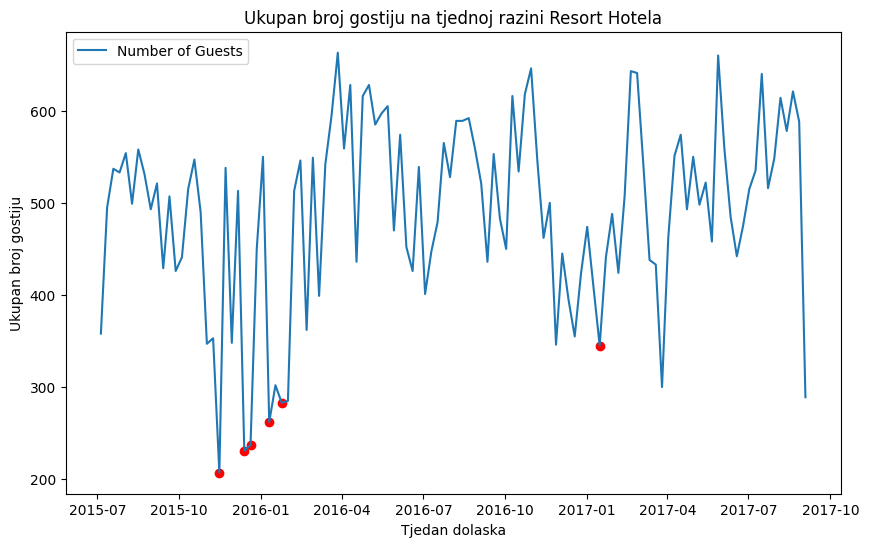

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_resort[anomalies_resort].index:
    if anomaly_date in NumberOfGuestsWeeklyResort.index:
        plt.scatter(anomaly_date, NumberOfGuestsWeeklyResort.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini Resort Hotela')
plt.legend()
plt.show()

In [20]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies_city = outlier_detector.fit_detect(NumberOfGuestsWeeklyCity)

/home/mharalovic/Prediction-of-Hotel-Occupancy/prediction-of-hotel-occupancy/env/lib/python3.10/site-packages/adtk/detector/_detector_hd.py:183: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False  True  True  True  True  True False False False
 False False False False False False False False False False False Fa

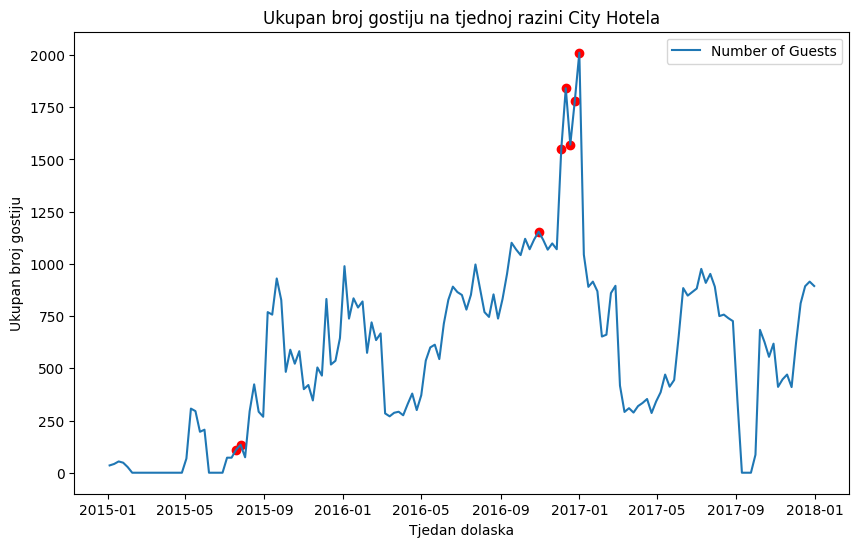

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Number of Guests')

for anomaly_date in anomalies_city[anomalies_city].index:
    if anomaly_date in NumberOfGuestsWeeklyCity.index:
        plt.scatter(anomaly_date, NumberOfGuestsWeeklyCity.loc[anomaly_date, 'ukupno_gostiju'], color='red')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Ukupan broj gostiju')
plt.title('Ukupan broj gostiju na tjednoj razini City Hotela')
plt.legend()
plt.show()

## (Unsupervised) Isolation Forests na univarijatnim podacima 

A sliding window is a common technique for analyzing time series data. It involves dividing the data into overlapping or non-overlapping chunks, or “windows,” and analyzing each window separately. This can be useful for identifying patterns or trends that may not be apparent when analyzing the entire dataset.

To use a sliding window with the isolation forest algorithm for anomaly detection, you can concatenate the data of each window and apply the algorithm to the resulting data matrix.

they do not require any feature engineering (such as normalizing, resampling and scaling)

 Isolation Score for the Isolation Forest


 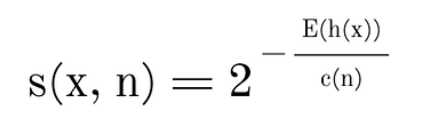

- h(x) - This is the average search height for 'x' from the isolation trees constructed 
- c(n) is the average search height (or depth) to find any general node in your isolation trees
- n is the number of external nodes in the Binary Search Tree (sample size)
- Note: External nodes are leaf nodes that could not be split further and reside at the bottom of the tree. 

In [22]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

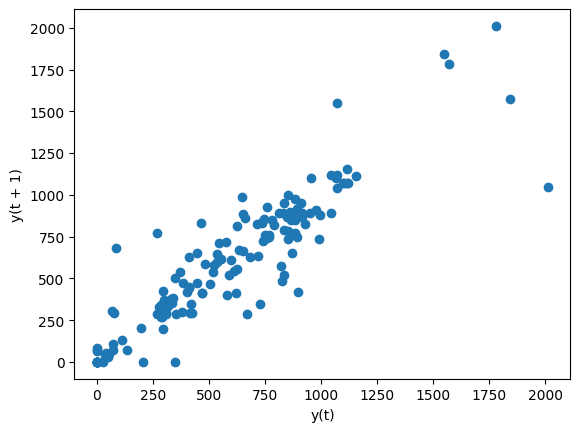

In [23]:
pd.plotting.lag_plot(NumberOfGuestsWeeklyCity, lag=1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

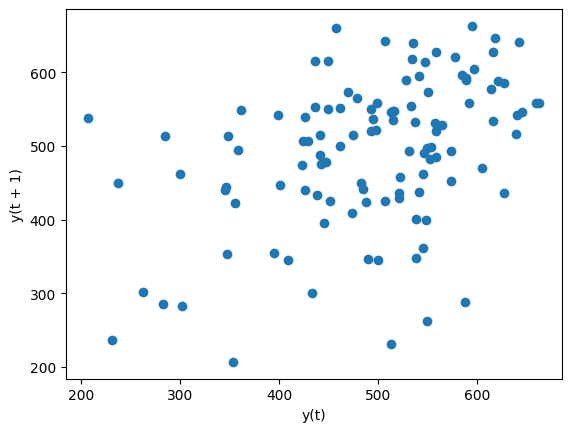

In [24]:
pd.plotting.lag_plot(NumberOfGuestsWeeklyResort, lag=1)

In [25]:
outliers_fraction = float(0.05)

In [26]:
if_model_city = IsolationForest(random_state = 0, 
                                contamination = outliers_fraction,
                                bootstrap=False,
                                verbose=True
                                )

In [27]:
city_data = NumberOfGuestsWeeklyCity['ukupno_gostiju'].values.reshape(-1,1)

In [28]:
scaler = StandardScaler()
city_data_stand = scaler.fit_transform(city_data)

In [29]:
if_model_city.fit(city_data_stand)

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [30]:
NumberOfGuestsWeeklyCity['score'] = if_model_city.decision_function(city_data_stand)
NumberOfGuestsWeeklyCity['anomaly_value'] = if_model_city.predict(city_data_stand)
NumberOfGuestsWeeklyCity.head()

,ukupno_gostiju,score,anomaly_value
datum_dolaska,,,
2015-01-04,35.0,0.022843,1
2015-01-11,42.0,0.031476,1
2015-01-18,54.0,0.029678,1
2015-01-25,48.0,0.041035,1
2015-02-01,27.0,-0.009033,-1


anomaly_value
 1    149
-1      8
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

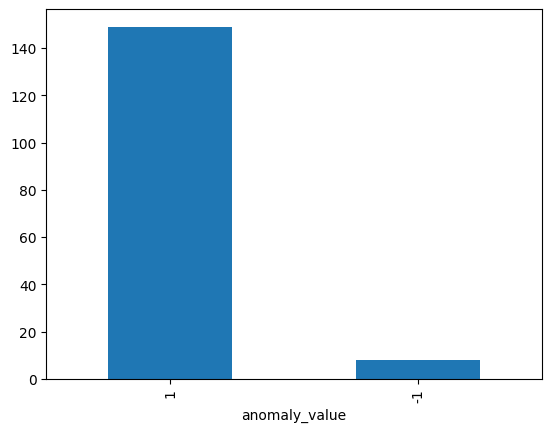

In [31]:
outliers_city = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value'] == -1]
outlier_index = list(outliers_city.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsWeeklyCity['anomaly_value'].value_counts())
NumberOfGuestsWeeklyCity['anomaly_value'].value_counts().plot(kind = 'bar')

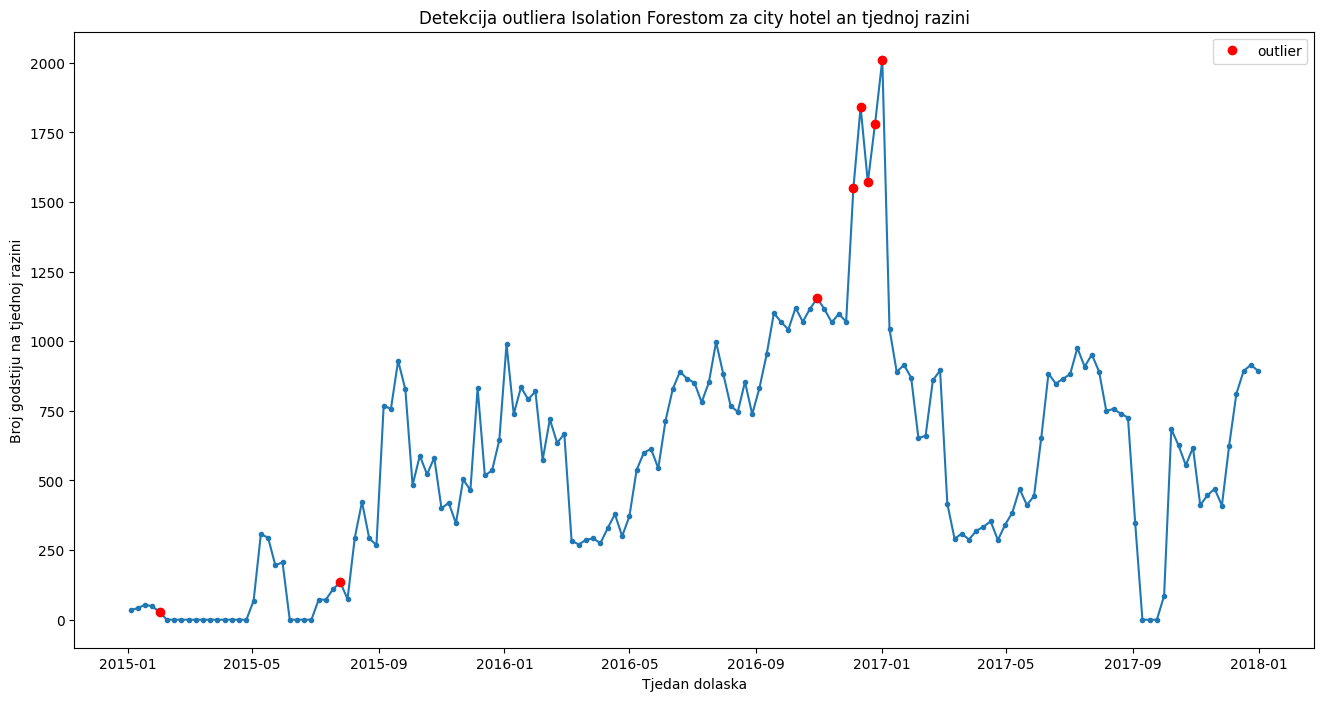

In [32]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker = '.')
plt.plot(outliers_city['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za city hotel an tjednoj razini')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj godstiju na tjednoj razini')
plt.legend()

In [33]:
outliers_fraction = float(0.05)

In [34]:
if_model_resort = IsolationForest(random_state = 0, 
                                  contamination = outliers_fraction ,
                                  bootstrap=False,
                                  verbose=True
                                 )

In [35]:
resort_data = NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1)

In [36]:
scaler = StandardScaler()
resort_data_stand = scaler.fit_transform(resort_data )

In [37]:
if_model_resort.fit(resort_data_stand) #if_model_resort.fit(NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1)) 

IsolationForest(contamination=0.05, random_state=0, verbose=True)

In [38]:
NumberOfGuestsWeeklyResort['score'] = if_model_resort.decision_function(resort_data_stand) #if_model_resort.decision_function(NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1))
NumberOfGuestsWeeklyResort['anomaly_value'] = if_model_resort.predict(resort_data_stand) #if_model_resort.predict(NumberOfGuestsWeeklyResort['ukupno_gostiju'].values.reshape(-1,1)) 
NumberOfGuestsWeeklyResort.head()

,ukupno_gostiju,score,anomaly_value
datum_dolaska,,,
2015-07-05,358.0,0.073555,1
2015-07-12,495.0,0.168078,1
2015-07-19,537.0,0.190954,1
2015-07-26,533.0,0.179562,1
2015-08-02,554.0,0.171272,1


anomaly_value
 1    108
-1      6
Name: count, dtype: int64


<Axes: xlabel='anomaly_value'>

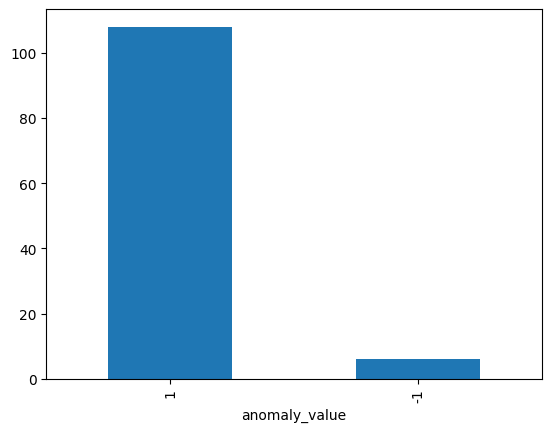

In [39]:
outliers_resort = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value'] == -1]
outlier_index_resort = list(outliers_resort.index)

#1 - nije outlier, -1 - outlier
print(NumberOfGuestsWeeklyResort['anomaly_value'].value_counts())
NumberOfGuestsWeeklyResort['anomaly_value'].value_counts().plot(kind = 'bar')

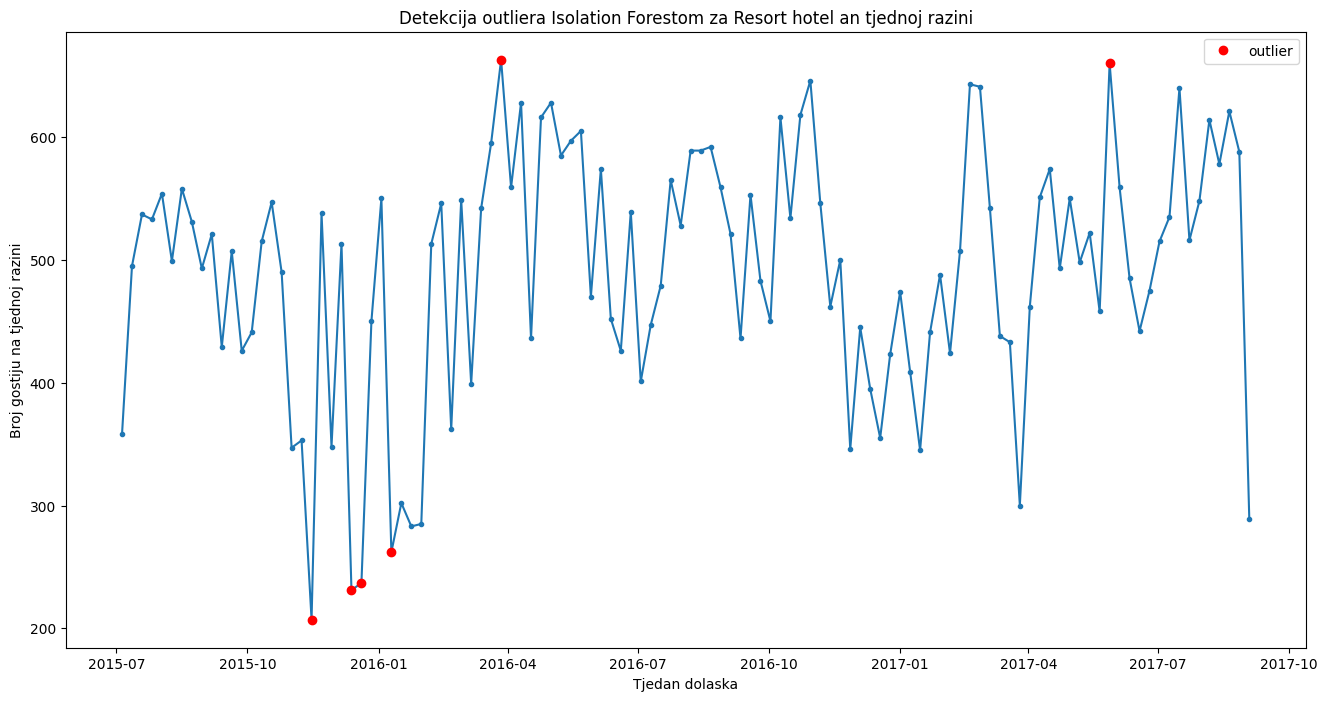

In [40]:
plt.figure(figsize = (16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker = '.')
plt.plot(outliers_resort['ukupno_gostiju'], 'o', color = 'red', label = 'outlier')
plt.title('Detekcija outliera Isolation Forestom za Resort hotel an tjednoj razini')

plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()

## One class SVM

In [41]:
from sklearn.svm import OneClassSVM

In [42]:
outliers_fraction = float(0.05)

In [43]:
osvm_city = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_city.fit(city_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [44]:
NumberOfGuestsWeeklyCity['anomaly_value_osvm'] = osvm_city.predict(city_data_stand)

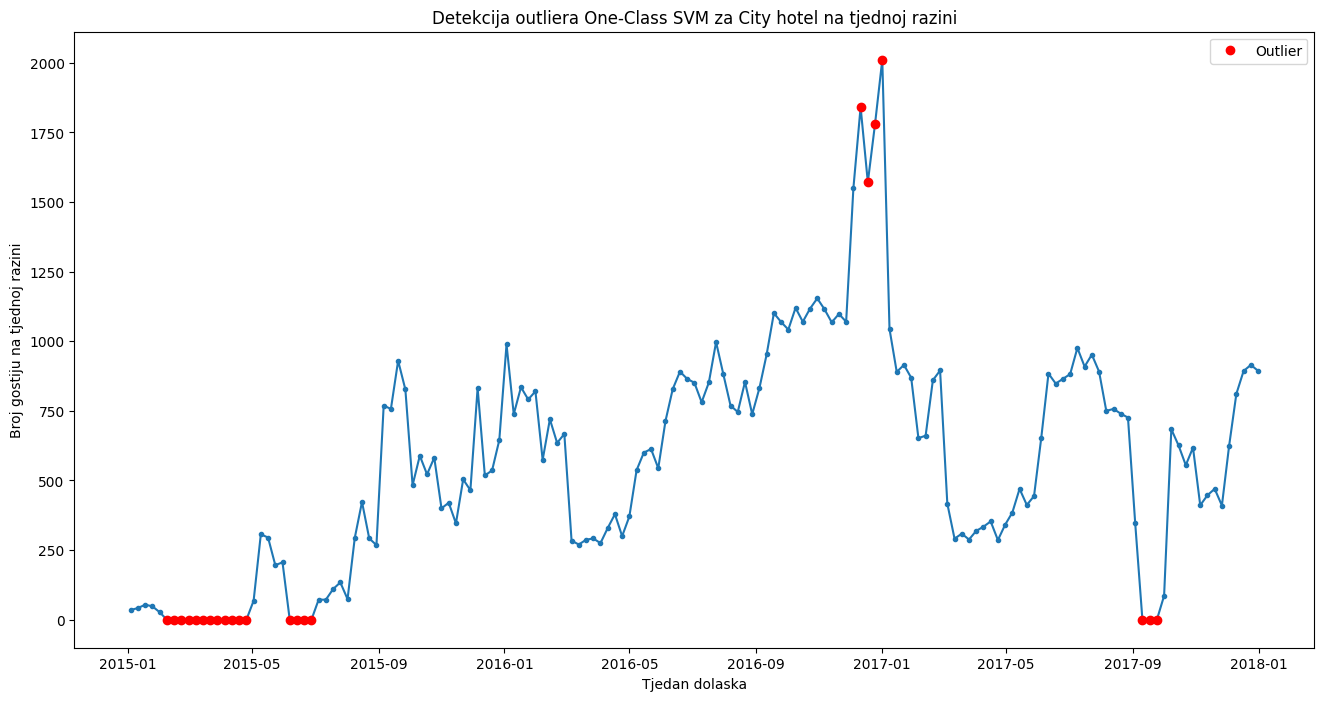

In [45]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za City hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


In [46]:
osvm_resort = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)
osvm_resort.fit(resort_data_stand)



OneClassSVM(gamma=0.01, nu=0.05)

In [47]:
NumberOfGuestsWeeklyResort['anomaly_value_osvm'] = osvm_resort.predict(resort_data_stand)

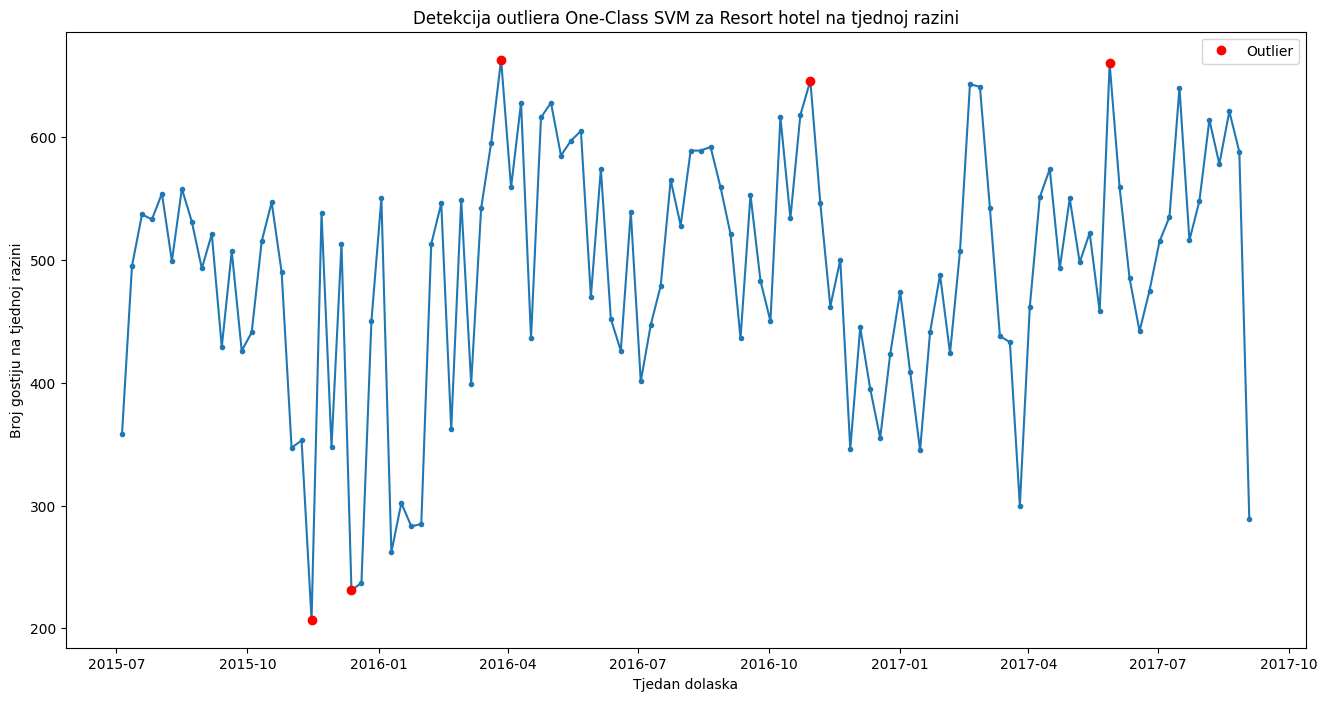

In [48]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker='.')

anomalies_osvm = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value_osvm'] == -1]
plt.plot(anomalies_osvm['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera One-Class SVM za Resort hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


## K Means Clustering

- To use K-Means as an anomaly detection method for time-series data, a sliding windows approach is used
- Note: Keogh and Lin have demonstrated in their work that using sub-sequences of time-series for
clustering algorithms is meaningless. They showed, that the cluster centers found for several runs of the
K-means algorithm on the same dataset are not significantly more similar to each other than the cluster centers
of a random walk dataset. That means that after being asked to present the centroids on a dataset, they could
just present the centroids of a random walk and nobody would be able to distinguish between them.
They also tried other algorithms like hierarchical clustering, which is a deterministic approach compared to
K-means, but received the same result. The same was proved on several datasets which furthermore confirmed
their claim that using sub-sequences of the time-series data for clustering techniques is meaningless. They
also tried different distance measures like Manhattan, L∞ and Mahalanobis distance. Furthermore, by using
K-Means with k = 3 and w = 128 on the famous Cylinder, Bell and Funnell (CBF) dataset, they showed that
the resulting centroids are sinus waves, which are totally different to the instances in the CBF dataset. Several
authors tried to analyse this behavior mathematically , and there have been a lot of attempts to
solve these problem, or at least to show time-series patterns that would work with STSC ]. But the
problems remain generally unsolved.

##### Nedostaci K Means Clusteringa kao metode za detekciju anomalija
- algoritam očekuje da skupine imaju slične oblike,inače ih slabo odvaja
- sve točke idu u algoritam, anomalije pripadaju skupini te utječu na centroidu te radijus skupine (veća granica za detektirat)
- ako imamo dovoljan broj anomalija, skupinu mogu činiti i samo anomalije
- apriori definiranje broja skupina

In [171]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [172]:
resort_tmp = NumberOfGuestsWeeklyResort[['ukupno_gostiju']]

/tmp/ipykernel_2215498/2703005918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resort_tmp['ukupno_gostiju'] = scaler.fit_transform(resort_tmp['ukupno_gostiju'].values.reshape(-1,1))


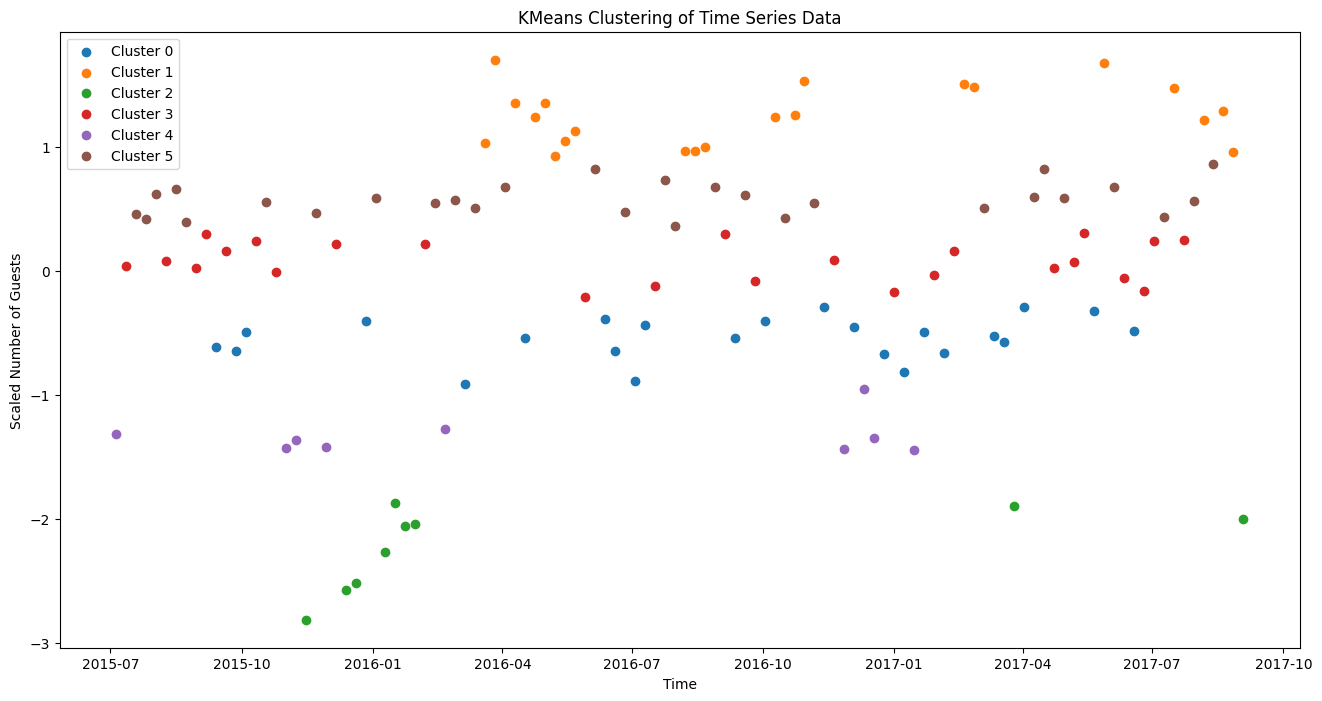

In [173]:
resort_tmp['ukupno_gostiju'] = scaler.fit_transform(resort_tmp['ukupno_gostiju'].values.reshape(-1,1))

kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(resort_tmp)
plt.figure(figsize=(16, 8))

for cluster in range(6):
    cluster_data = resort_tmp[clusters == cluster]
    plt.scatter(cluster_data.index, cluster_data['ukupno_gostiju'], label=f'Cluster {cluster}')

plt.title('KMeans Clustering of Time Series Data')
plt.xlabel('Time')
plt.ylabel('Scaled Number of Guests')
plt.legend()
plt.show()

In [174]:
NumberOfGuestsWeeklyResort['kmeans_clusters'] = clusters

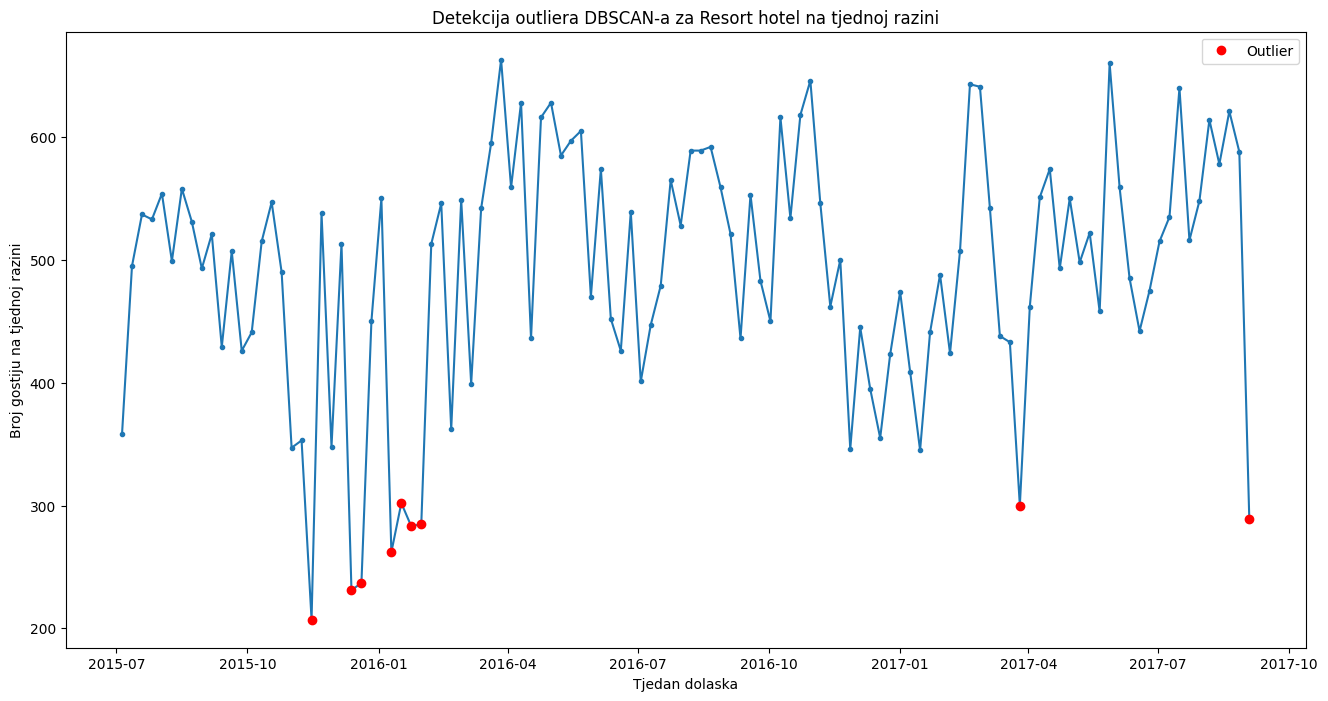

In [176]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker='.')

anomalies_kmeans = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['kmeans_clusters'] == 2]  #iiznimno sporno 
plt.plot(anomalies_kmeans['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za Resort hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


In [ ]:
resort_tmp['ukupno_gostiju'] = scaler.fit_transform(resort_tmp['ukupno_gostiju'].values.reshape(-1,1))
X = resort_tmp[['ukupno_gostiju']].values

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], np.zeros_like(X), marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], np.zeros_like(centers[:, 0]), marker="o", c="white", alpha=1, s=200, edgecolor="k")
    for i, c in enumerate(centers):
        ax2.scatter(c[0], 0, marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for 'ukupno_gostiju'")
    ax2.set_ylabel("Zeroes (One-dimensional data)")

    plt.suptitle("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold")

plt.show()

## DBSCAN

In [111]:
from sklearn.cluster import DBSCAN

-eps: float, default=0.5: 
The maximum distance between two samples for one to be considered as in the neighborhood of the othe.
rGlossary for more details.

-min_samples: int, default=5 : The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.

In [112]:
resort_tmp = NumberOfGuestsWeeklyResort
resort_tmp = resort_tmp.drop(columns=['score', 'anomaly_value', 'anomaly_value_osvm','anomaly_value_dbscan'])

In [113]:
resort_tmp['ukupno_gostiju'] = scaler.fit_transform(resort_tmp['ukupno_gostiju'].values.reshape(-1,1))
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_resort = outlier_detection.fit_predict(resort_tmp )

In [114]:
NumberOfGuestsWeeklyResort['anomaly_value_dbscan'] = clusters_resort


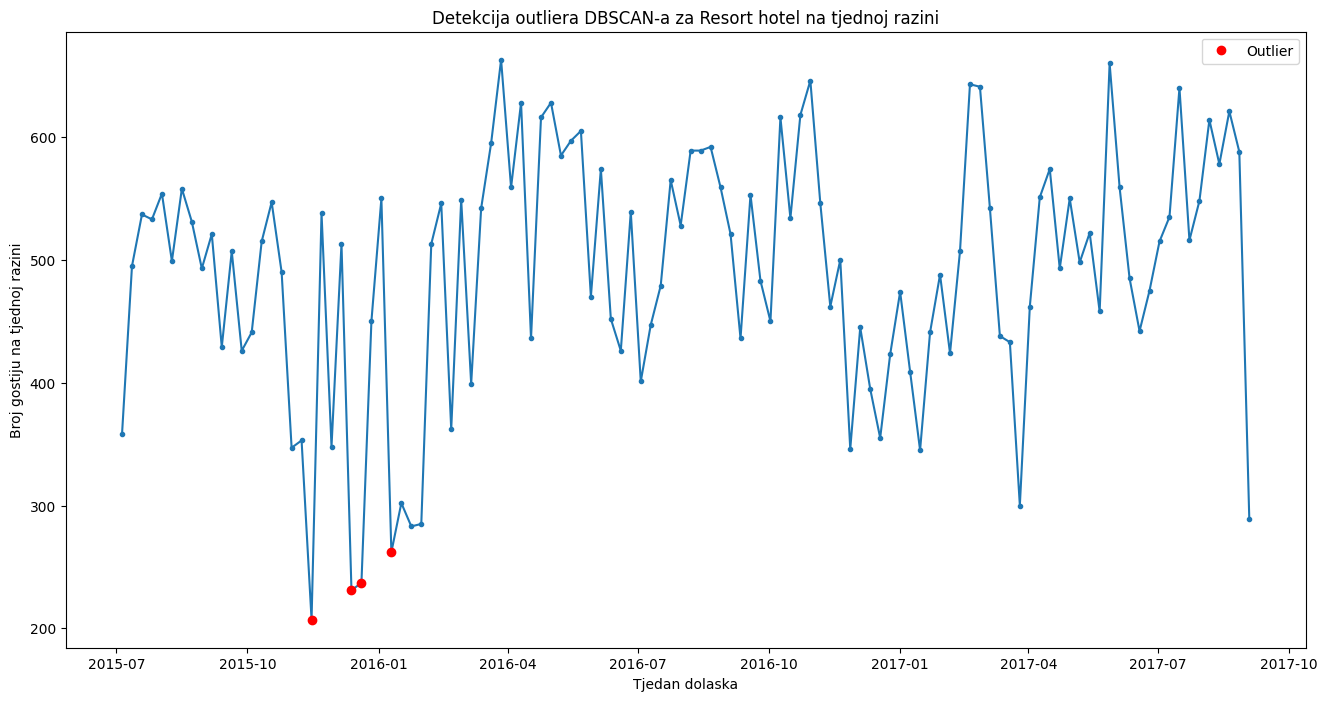

In [115]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyResort['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsWeeklyResort[NumberOfGuestsWeeklyResort['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za Resort hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()


In [116]:
city_tmp = NumberOfGuestsWeeklyCity #['ukupno_gostiju'].values.reshape(-1,1)
city_tmp = city_tmp.drop(columns=['score', 'anomaly_value', 'anomaly_value_osvm'])

In [117]:
city_tmp['ukupno_gostiju'] = scaler.fit_transform(city_tmp['ukupno_gostiju'].values.reshape(-1,1))
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters_city = outlier_detection.fit_predict(city_tmp)

In [118]:
NumberOfGuestsWeeklyCity['anomaly_value_dbscan'] = clusters_city


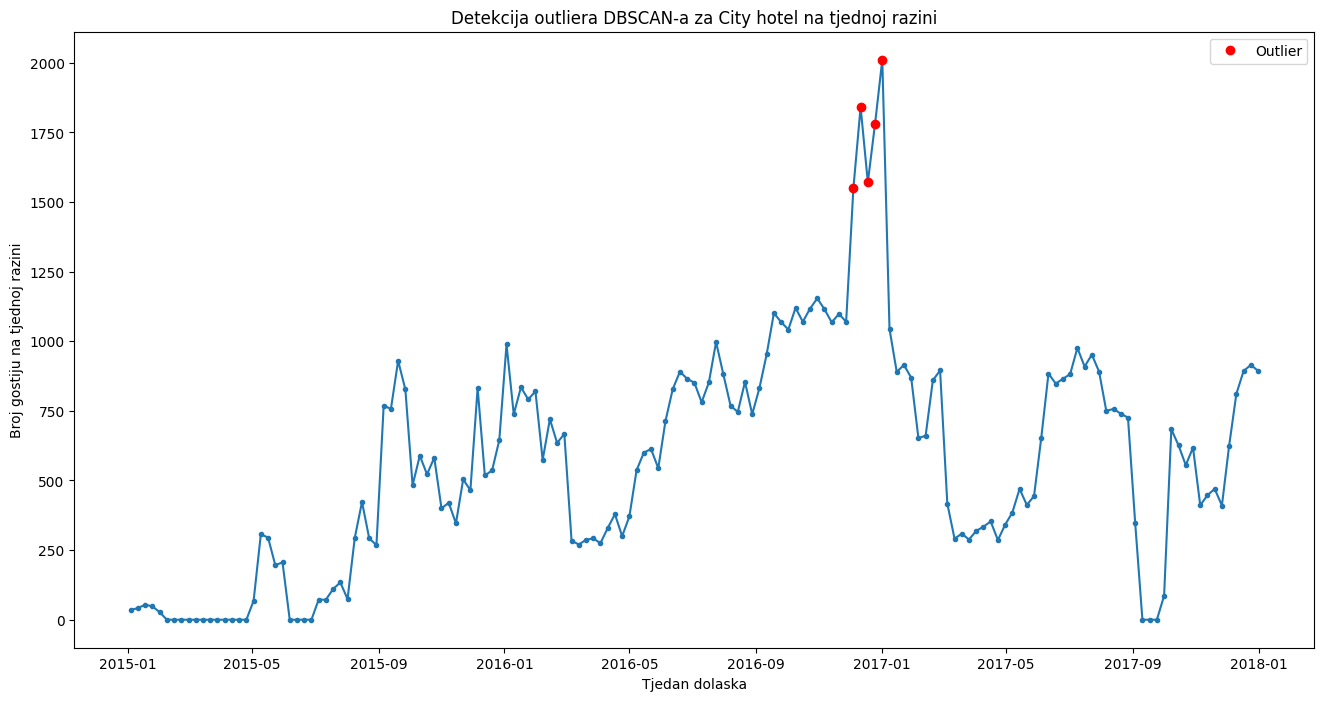

In [119]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.')

anomalies_dbscan = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['anomaly_value_dbscan'] == -1]
plt.plot(anomalies_dbscan['ukupno_gostiju'], 'o', color='red', label='Outlier')

plt.title('Detekcija outliera DBSCAN-a za City hotel na tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()
